# Predicting Loan Status

This notebook aimes to predict the loan status of a customer given a number of features in their loan application.

The data has many features, some categorical, some continous, and 1 target variable that is binary in nature

In [31]:
# dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

%matplotlib inline

In [2]:
# import the dataset
url = "https://raw.githubusercontent.com/callxpert/datasets/master/Loan-applicant-details.csv"
columns = ['Loan_ID','Gender','Married','Dependents','Education','Self_Employed','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History','Property_Area','Loan_Status']
df = pd.read_csv(url, names=columns)

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128,360,1,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66,360,1,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360,1,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141,360,1,Urban,Y
4,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267,360,1,Urban,Y


In [4]:
len(df) == df.Loan_ID.nunique()

True

In [5]:
# we can drop the load column because each row is unique
df = df.drop(columns=["Loan_ID"])

In [6]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,No,4583,1508.0,128,360,1,Rural,N
1,Male,Yes,0,Graduate,Yes,3000,0.0,66,360,1,Urban,Y
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120,360,1,Urban,Y
3,Male,No,0,Graduate,No,6000,0.0,141,360,1,Urban,Y
4,Male,Yes,2,Graduate,Yes,5417,4196.0,267,360,1,Urban,Y


In [7]:
# for the categorical variables, we want to see how many unique values are in each.
# this way we can determine if it makes sense to delete features (we don't want a million dummy variables)
df.Gender.value_counts()

Male      394
Female     86
Name: Gender, dtype: int64

In [8]:
df.Married.value_counts()

Yes    311
No     169
Name: Married, dtype: int64

In [9]:
df.Education.value_counts()

Graduate        383
Not Graduate     97
Name: Education, dtype: int64

In [10]:
df.Property_Area.value_counts()

Semiurban    191
Urban        150
Rural        139
Name: Property_Area, dtype: int64

In [11]:
# convert mututally exclusive column values to binary
df["Gender"] = df["Gender"].apply(lambda value: 0 if value == "Female" else 1)
df["Married"] = df["Married"].apply(lambda value: 0 if value == "No" else 1)
df["Education"] = df["Education"].apply(lambda value: 0 if value == "Not Graduate" else 1)
df["Self_Employed"] = df["Self_Employed"].apply(lambda value: 0 if value == "No" else 1)
df["Loan_Status"] = df["Loan_Status"].apply(lambda status: 0 if status == "N" else 1)

In [12]:
# rename the columns we changed so they make more sense
df = df.rename(
    columns={
        "Gender": "Male",
        "Education": "Graduated"
    }
)

In [13]:
df.head()

,Male,Married,Dependents,Graduated,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,1,1,1,0,4583,1508.0,128,360,1,Rural,0
1,1,1,0,1,1,3000,0.0,66,360,1,Urban,1
2,1,1,0,0,0,2583,2358.0,120,360,1,Urban,1
3,1,0,0,1,0,6000,0.0,141,360,1,Urban,1
4,1,1,2,1,1,5417,4196.0,267,360,1,Urban,1


In [14]:
# make sure the incomes are at their correct unit, right now, they're in 10s
df["ApplicantIncome"] = df["ApplicantIncome"].apply(lambda income: income*10)
df["LoanAmount"] = df["LoanAmount"].apply(lambda amount: amount*10)

In [15]:
df = pd.get_dummies(df)

In [16]:
df.head()

,Male,Married,Graduated,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,1,1,0,45830,1508.0,1280,360,1,0,0,1,0,0,1,0,0
1,1,1,1,1,30000,0.0,660,360,1,1,1,0,0,0,0,0,1
2,1,1,0,0,25830,2358.0,1200,360,1,1,1,0,0,0,0,0,1
3,1,0,1,0,60000,0.0,1410,360,1,1,1,0,0,0,0,0,1
4,1,1,1,1,54170,4196.0,2670,360,1,1,0,0,1,0,0,0,1


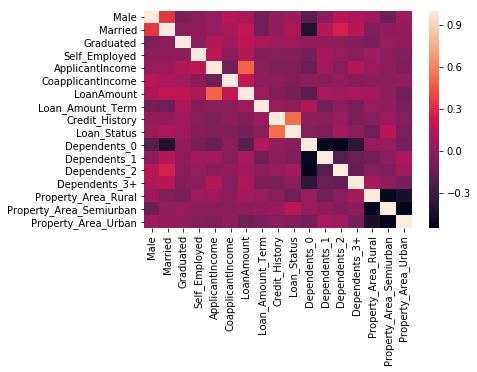

In [17]:
# see the correlation between the features
sns.heatmap(df.corr())

In [18]:
# split into features and target
features = df.drop(columns=["Loan_Status"])
target = df["Loan_Status"]

In [19]:
# create the train test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=20)

In [20]:
# logistic regression
logistic_regression_model = LogisticRegression()

# fit the logisic regression model to the data first
logistic_regression_model.fit(X_train, y_train)

# evaluate
train_accuracies = cross_val_score(logistic_regression_model, X_train, y_train, cv=10)
test_accuracies = cross_val_score(logistic_regression_model, X_test, y_test, cv=10)
whole_sample_accuracies = cross_val_score(logistic_regression_model, features, target, cv=10)

In [21]:
print("Training Cross Validation Score: {}".format(train_accuracies.mean()))
print("Testing Cross Validation Score: {}".format(test_accuracies.mean()))
print("Whole Sample Cross Validation Score: {}".format(whole_sample_accuracies.mean()))

Training Cross Validation Score: 0.6926286610497137
Testing Cross Validation Score: 0.7822222222222222
Whole Sample Cross Validation Score: 0.6896177087856419


In [22]:
# lasso model
lasso_model = Lasso(alpha=0.03)

# fit the lasso model
lasso_model.fit(X_train, y_train)

# evaluate the model
train_accuracy = lasso_model.score(X_train, y_train)
test_accuracy = lasso_model.score(X_test, y_test)
whole_sample_accuracy = lasso_model.score(features, target)

In [23]:
print("Training Cross Validation Score: {}".format(train_accuracy))
print("Testing Cross Validation Score: {}".format(test_accuracy))
print("Whole Sample Cross Validation Score: {}".format(whole_sample_accuracy))

Training Cross Validation Score: 0.21666367700438668
Testing Cross Validation Score: 0.293122353797713
Whole Sample Cross Validation Score: 0.23208463590574058


In [30]:
# ridge model

ridge_model = Ridge()

# fit the ridge model
ridge_model.fit(X_train, y_train)

# evaluate the model
print(ridge_model.score(X_test, y_test))

0.3694336297251932


In [ ]:
# Logistic Regression did much better, im not sure why tho

In [32]:
# baseline RandomForrest
rfc = RandomForestClassifier(criterion="entropy")

rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
rfc.score(X_test, y_test)

0.8020833333333334

In [45]:
lr = LogisticRegression(penalty="l1")
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))

0.8541666666666666
